<a href="https://colab.research.google.com/github/ahmadrathore/Provisioning-SmartX-MicroBox/blob/master/Forecasting_Network_flows_from_Cloud_native_Edge_Boxes_using_Multivariate_Multi_step_Time_SeriesStacked_LSTM_sequence_to_sequence_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Multivariate Multistep Time Series Forecasting using Stacked LSTM sequence to sequence Autoencoder in Tensorflow 2.0 / Keras 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os

Downloading the dataset

In [ ]:
url='https://raw.githubusercontent.com/ahmadrathore/Provisioning-SmartX-MicroBox/master/kafka9092_Network-Flows_1.csv'

df=pd.read_csv(url, sep=',', header=0, low_memory=False, infer_datetime_format=True, index_col=['Processing_time'], parse_dates=True)
df.head()

,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes
Processing_time,,,,,,,,,
2020-12-01 00:05:24.998000+09:00,2438,2439,2439,0.07,161,11888,2788.26,2591.23,510252
2020-12-01 00:10:44.861000+09:00,2438,2439,2439,0.11,63,11856,2228.37,2094.46,882435
2020-12-01 00:15:33.979000+09:00,2438,2439,2439,0.13,102,13084,2209.62,2321.09,872801
2020-12-01 00:25:41.464000+09:00,2438,2439,2439,0.09,61,11550,1989.66,1919.81,913254
2020-12-01 00:35:18.114000+09:00,2438,2439,2439,0.09,87,11544,1981.21,1909.48,903430


**Imputing Null values**

In [ ]:
df = df.replace('?', np.nan)
df.isnull().sum()

min_tcp_window_size        0
max_tcp_window_size        0
avg_tcp_window_size        0
std_dev_tcp_window_size    0
min_data_bytes             0
max_data_bytes             0
avg_databytes              0
std_dev_databytes          0
total_data_bytes           0
dtype: int64

In [ ]:
def fill_missing(values):
    one_day = 60*24
    for row in range(df.shape[0]):
        for col in range(df.shape[1]):
            if np.isnan(values[row][col]):
                values[row,col] = values[row-one_day,col]


#from sklearn.preprocessing import LabelEncoder
#for column in df.columns:
#    if df[column].dtype == type(object):
#        le = LabelEncoder()
#        df[column] = le.fit_transform(df[column])

df = df.astype('float32')
fill_missing(df.values)
df.isnull().sum()

min_tcp_window_size        0
max_tcp_window_size        0
avg_tcp_window_size        0
std_dev_tcp_window_size    0
min_data_bytes             0
max_data_bytes             0
avg_databytes              0
std_dev_databytes          0
total_data_bytes           0
dtype: int64

Downsampling of Data from minutes to Days 

In [ ]:
daily_df = df.resample('H').sum()
daily_df.head()

,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes
Processing_time,,,,,,,,,
2020-12-01 00:00:00+09:00,21941.0,21951.0,21951.0,0.94,786.0,106755.0,20098.960938,19681.630859,7611554.0
2020-12-01 01:00:00+09:00,29249.0,29268.0,29268.0,1.52,842.0,147690.0,26204.730469,26742.371094,10279206.0
2020-12-01 02:00:00+09:00,26816.0,26829.0,26829.0,1.03,790.0,127395.0,24386.759766,24530.080078,9352916.0
2020-12-01 03:00:00+09:00,26817.0,26829.0,26829.0,1.01,834.0,124539.0,24384.160156,24481.349609,9347045.0
2020-12-01 04:00:00+09:00,29256.0,29268.0,29268.0,1.13,882.0,144260.0,25947.230469,26051.650391,9883890.0


In [ ]:
daily_df.describe()

,min_tcp_window_size,max_tcp_window_size,avg_tcp_window_size,std_dev_tcp_window_size,min_data_bytes,max_data_bytes,avg_databytes,std_dev_databytes,total_data_bytes
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.00
mean,26271.232422,26287.058594,26282.089844,3.596070,872.956360,116522.257812,23869.136719,23240.828125,8638743.00
std,5198.701172,5187.164551,5196.750977,9.625584,108.052498,21899.902344,2780.807129,3145.495605,1393831.25
min,4688.000000,4721.000000,4692.000000,0.000000,197.000000,36993.000000,6272.860352,6210.410156,2328323.00
25%,26730.750000,26800.500000,26779.750000,0.300000,827.000000,100602.000000,22845.142578,21746.401855,7921705.50
50%,29252.000000,29268.000000,29268.000000,0.785000,885.000000,111941.500000,24065.929688,22896.160156,8128128.50
75%,29259.250000,29268.000000,29268.000000,1.130000,940.250000,139163.750000,26198.526855,26198.841797,10221167.50
max,29268.000000,29268.000000,29268.000000,96.869995,1205.000000,147971.000000,27978.419922,28264.599609,10376318.00


In [ ]:
daily_df.shape, df.shape

((756, 9), (8576, 9))

In [ ]:
# For this case, let's assume that
# Given past 10 days observation, forecast the next 5 days observations. 
#n_past = 25
#n_future = 5 
#n_past = 24
#n_future =1

# Hours or Days Unit
#n_past = 24 # Total hours = 8500+, 168 hours = 7 days
n_past = 12 
n_future = 6
n_features =9

Train - Test Split

In [ ]:
#train_df,test_df = daily_df[1:982], daily_df[982:]  # 75% and 25% Unit is 30 min
train_df,test_df = daily_df[1:491], daily_df[491:]  # 65% and 35% Unit is one Hour
#train_df,test_df = daily_df[1:567], daily_df[567:]  # 75% and 25% Unit is one Hour
#train_df,test_df = daily_df[1:80], daily_df[80:]  # 75% and 25% Unit is 6 Hours
#train_df,test_df = daily_df[1:40], daily_df[40:]  # 75% and 25% Unit is 12 Hours,(63, 9)
#train_df,test_df = daily_df[1:245], daily_df[245:]  # 75% and 25% Unit is 2 Hours,(63, 9)
#train_df,test_df = daily_df[1:20], daily_df[20:]  # 75% and 25% in days
train_df.shape,test_df.shape

((490, 9), (265, 9))

In [ ]:
np.shape(train_df)


(490, 9)

In [ ]:
np.shape(test_df)

(265, 9)

Scaling the values for faster training of the models.

In [ ]:
train = train_df
scalers={}

for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

**Converting the series to samples for supervised learning**

In [ ]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
  X, y = list(), list()
  for window_start in range(len(series)):
    past_end = window_start + n_past
    future_end = past_end + n_future
    if future_end > len(series):
      break
    # slicing the past and future parts of the window
    past, future = series[window_start:past_end, :], series[past_end:future_end, :]
    X.append(past)
    y.append(future)
  return np.array(X), np.array(y)

In [ ]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
X_test.shape

(248, 12, 9)

**Model Architecture**

E1D1 ==> Sequence to Sequence Model with one encoder layer and one decoder layer. 

E2D2 ==> Sequence to Sequence Model with two encoder layers and two decoder layers. 

In [ ]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)
#
model_e1d1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 12, 9)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 44000       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 6, 100)       0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 6, 100)       80400       repeat_vector[0][0]              
                                                                 lstm[0][1]                   

In [ ]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 12, 9)]      0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 12, 100), (N 44000       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 100), (None, 80400       lstm_2[0][0]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 6, 100)       0           lstm_3[0][0]                     
____________________________________________________________________________________________

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

 **Training the models**


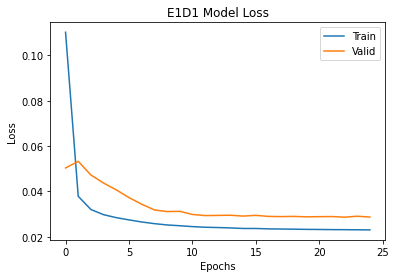

In [ ]:
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title("E1D1 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [ ]:
history_e1d1.history['loss'],history_e1d1.history['val_loss']

([0.11018697172403336,
  0.03786955773830414,
  0.032051462680101395,
  0.02975241281092167,
  0.02845192514359951,
  0.027463942766189575,
  0.02654745802283287,
  0.025809433311223984,
  0.025241877883672714,
  0.024889245629310608,
  0.024505941197276115,
  0.024219708517193794,
  0.02409692294895649,
  0.023923395201563835,
  0.02368033677339554,
  0.02367839589715004,
  0.023505620658397675,
  0.02343362756073475,
  0.023364564403891563,
  0.023288007825613022,
  0.023237572982907295,
  0.023180443793535233,
  0.023150082677602768,
  0.023100899532437325,
  0.02304377593100071],
 [0.050345469266176224,
  0.05327720567584038,
  0.04725894331932068,
  0.043701473623514175,
  0.04070226848125458,
  0.037297509610652924,
  0.03438583388924599,
  0.031860630959272385,
  0.031134020537137985,
  0.031238006427884102,
  0.029860086739063263,
  0.029367271810770035,
  0.02943572774529457,
  0.029516752809286118,
  0.029138395562767982,
  0.029467251151800156,
  0.02900121547281742,
  0.028

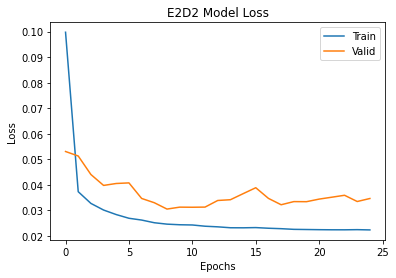

In [ ]:
plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title("E2D2 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

Prediction on validation set

In [ ]:
pred1_e1d1=model_e1d1.predict(X_test)
pred1_e2d2=model_e2d2.predict(X_test)

pred_e1d1=model_e1d1.predict(X_train)
pred_e2d2=model_e2d2.predict(X_train)

Inverse Scaling of the predicted values

In [ ]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    
    pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [ ]:
#def mean_absolute_percentage_error(y_true, y_pred): 
        #y_true, y_pred = np.array(y_true), np.array(y_pred)
        #return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    #print('Evaluation metric results:-')
    #print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    #print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    #print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    #print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    #print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

**Checking Error** 

min_tcp_window_size

Day  1 :
MAE-E1D1 :  2159.7498,     MAE-E2D2 :  2635.3616
MSE-E1D1 :  9215841.0, MSE-E2D2 :  11362729.0
RMSE-E1D1 :  3035.7603,     NRMSE-E1D1 :  0.14645799,     RMSE-E2D2 :  3370.8647
MAPE-E1D1 :  11.27801239490509,     MAPE-E1D1 :  12.843039631843567


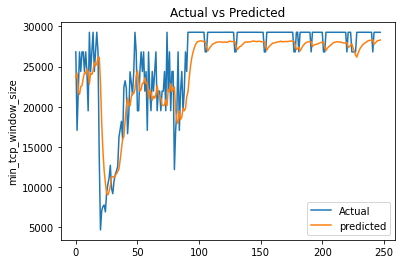

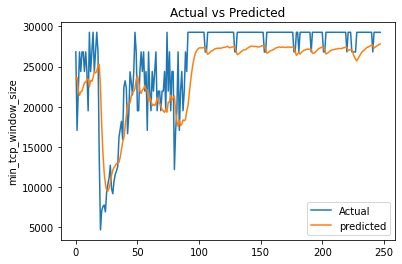


Day  2 :
MAE-E1D1 :  2304.989,     MAE-E2D2 :  2893.0762
MSE-E1D1 :  10888598.0, MSE-E2D2 :  13702156.0
RMSE-E1D1 :  3299.7876,     NRMSE-E1D1 :  0.16384746,     RMSE-E2D2 :  3701.6423
MAPE-E1D1 :  12.408347427845001,     MAPE-E1D1 :  14.151021838188171


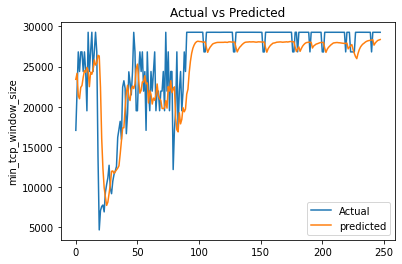

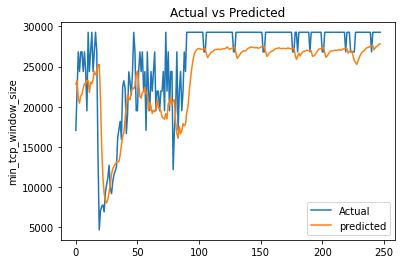


Day  3 :
MAE-E1D1 :  2495.5833,     MAE-E2D2 :  3134.5576
MSE-E1D1 :  12762602.0, MSE-E2D2 :  16377402.0
RMSE-E1D1 :  3572.4785,     NRMSE-E1D1 :  0.18153642,     RMSE-E2D2 :  4046.9004
MAPE-E1D1 :  13.568517565727234,     MAPE-E1D1 :  15.392714738845825


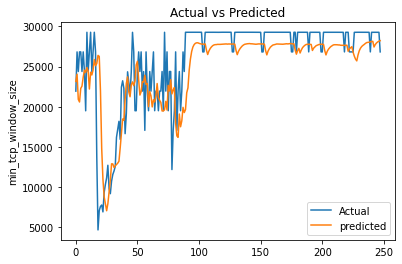

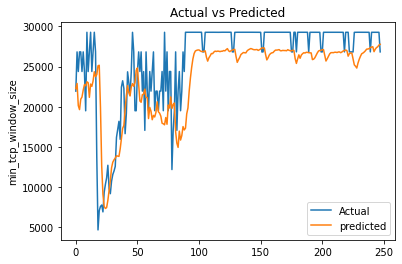


Day  4 :
MAE-E1D1 :  2718.1594,     MAE-E2D2 :  3454.154
MSE-E1D1 :  15036415.0, MSE-E2D2 :  19517724.0
RMSE-E1D1 :  3877.6816,     NRMSE-E1D1 :  0.19982746,     RMSE-E2D2 :  4417.8867
MAPE-E1D1 :  14.813987910747528,     MAPE-E1D1 :  16.965921223163605


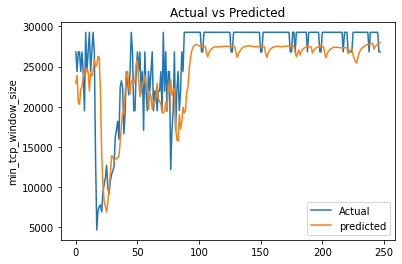

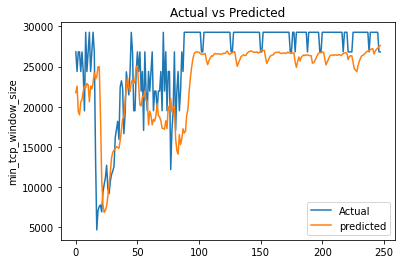


Day  5 :
MAE-E1D1 :  2988.1016,     MAE-E2D2 :  3795.1106
MSE-E1D1 :  17255898.0, MSE-E2D2 :  22723766.0
RMSE-E1D1 :  4154.022,     NRMSE-E1D1 :  0.21658486,     RMSE-E2D2 :  4766.9453
MAPE-E1D1 :  16.288714110851288,     MAPE-E1D1 :  18.57401132583618


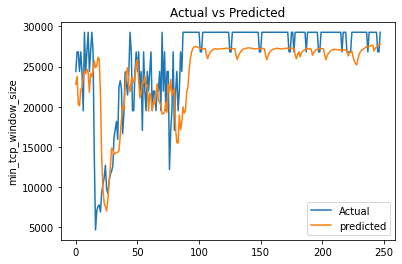

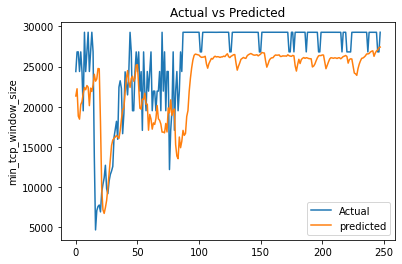



max_tcp_window_size

Day  1 :
MAE-E1D1 :  2526.8171,     MAE-E2D2 :  2788.07
MSE-E1D1 :  10461575.0, MSE-E2D2 :  12289032.0
RMSE-E1D1 :  3234.4358,     NRMSE-E1D1 :  0.15396997,     RMSE-E2D2 :  3505.5715
MAPE-E1D1 :  12.32556700706482,     MAPE-E1D1 :  13.266126811504364


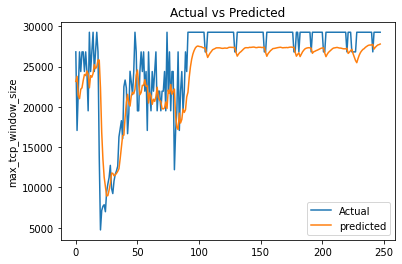

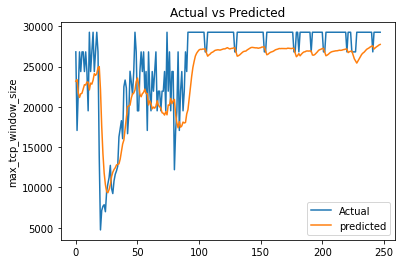


Day  2 :
MAE-E1D1 :  2441.866,     MAE-E2D2 :  2867.4375
MSE-E1D1 :  11208749.0, MSE-E2D2 :  13518158.0
RMSE-E1D1 :  3347.947,     NRMSE-E1D1 :  0.16227931,     RMSE-E2D2 :  3676.7048
MAPE-E1D1 :  12.795078754425049,     MAPE-E1D1 :  14.025913178920746


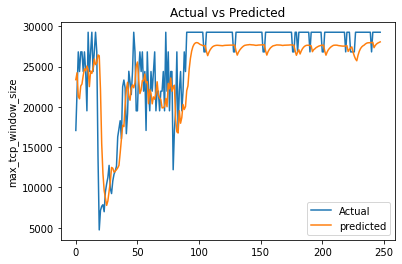

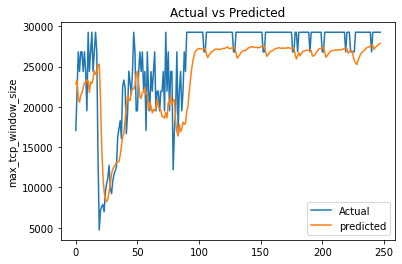


Day  3 :
MAE-E1D1 :  2524.494,     MAE-E2D2 :  3033.4314
MSE-E1D1 :  12676504.0, MSE-E2D2 :  15601450.0
RMSE-E1D1 :  3560.408,     NRMSE-E1D1 :  0.17555673,     RMSE-E2D2 :  3949.8672
MAPE-E1D1 :  13.641621172428131,     MAPE-E1D1 :  15.010926127433777


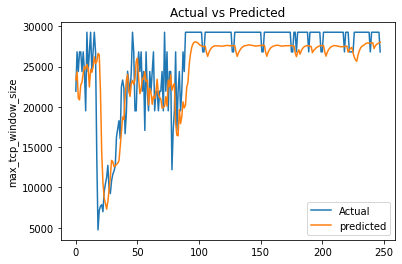

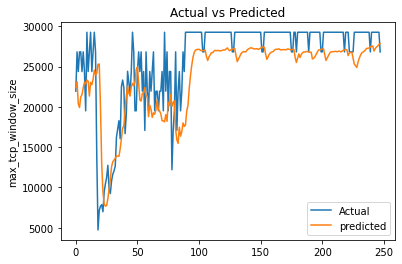


Day  4 :
MAE-E1D1 :  2679.519,     MAE-E2D2 :  3325.6465
MSE-E1D1 :  14713789.0, MSE-E2D2 :  18457222.0
RMSE-E1D1 :  3835.8557,     NRMSE-E1D1 :  0.19217572,     RMSE-E2D2 :  4296.187
MAPE-E1D1 :  14.687757194042206,     MAPE-E1D1 :  16.487939655780792


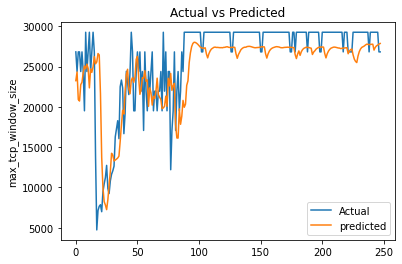

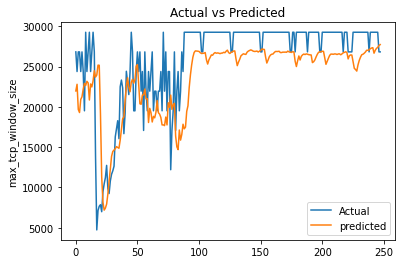


Day  5 :
MAE-E1D1 :  2920.766,     MAE-E2D2 :  3674.6528
MSE-E1D1 :  16849074.0, MSE-E2D2 :  21605322.0
RMSE-E1D1 :  4104.762,     NRMSE-E1D1 :  0.20900938,     RMSE-E2D2 :  4648.1523
MAPE-E1D1 :  16.094520688056946,     MAPE-E1D1 :  18.12952756881714


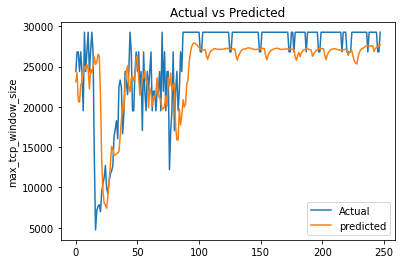

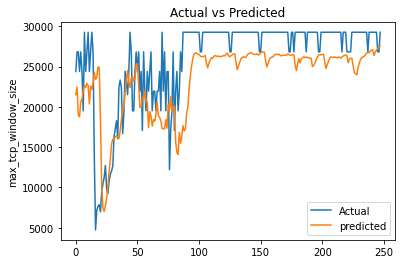



avg_tcp_window_size

Day  1 :
MAE-E1D1 :  2290.1838,     MAE-E2D2 :  2587.4998
MSE-E1D1 :  9563951.0, MSE-E2D2 :  11257139.0
RMSE-E1D1 :  3092.5637,     NRMSE-E1D1 :  0.14597905,     RMSE-E2D2 :  3355.166
MAPE-E1D1 :  11.888691782951355,     MAPE-E1D1 :  12.634463608264923


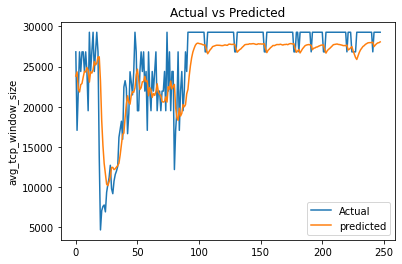

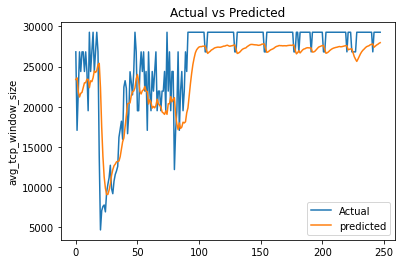


Day  2 :
MAE-E1D1 :  2388.2986,     MAE-E2D2 :  2846.8745
MSE-E1D1 :  10969398.0, MSE-E2D2 :  13472820.0
RMSE-E1D1 :  3312.008,     NRMSE-E1D1 :  0.16202892,     RMSE-E2D2 :  3670.534
MAPE-E1D1 :  12.745323777198792,     MAPE-E1D1 :  14.023657143115997


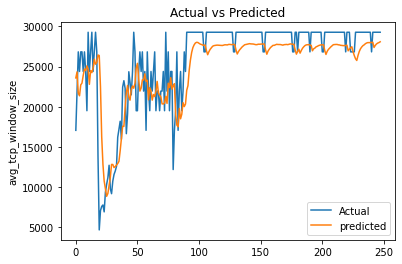

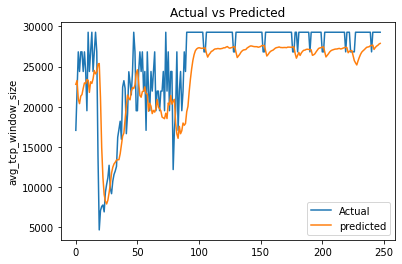


Day  3 :
MAE-E1D1 :  2516.304,     MAE-E2D2 :  3105.0667
MSE-E1D1 :  12542655.0, MSE-E2D2 :  16124009.0
RMSE-E1D1 :  3541.561,     NRMSE-E1D1 :  0.17944431,     RMSE-E2D2 :  4015.4712
MAPE-E1D1 :  13.635990023612976,     MAPE-E1D1 :  15.31122475862503


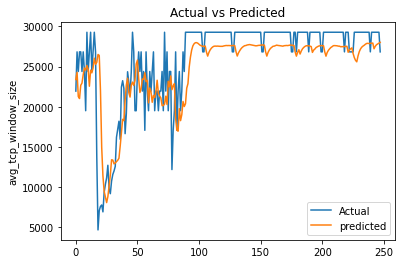

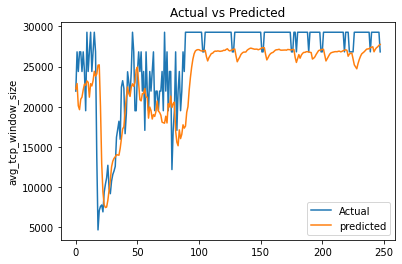


Day  4 :
MAE-E1D1 :  2668.7825,     MAE-E2D2 :  3443.0654
MSE-E1D1 :  14536671.0, MSE-E2D2 :  19358126.0
RMSE-E1D1 :  3812.6987,     NRMSE-E1D1 :  0.19847319,     RMSE-E2D2 :  4399.787
MAPE-E1D1 :  14.655540883541107,     MAPE-E1D1 :  16.897669434547424


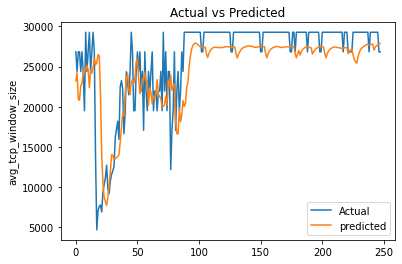

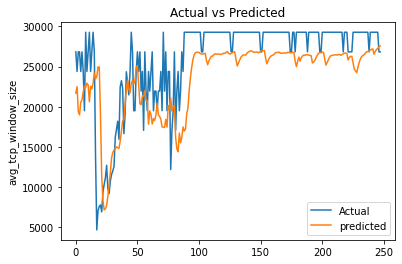


Day  5 :
MAE-E1D1 :  2875.068,     MAE-E2D2 :  3812.7397
MSE-E1D1 :  16539724.0, MSE-E2D2 :  22720606.0
RMSE-E1D1 :  4066.906,     NRMSE-E1D1 :  0.21650994,     RMSE-E2D2 :  4766.614
MAPE-E1D1 :  15.916816890239716,     MAPE-E1D1 :  18.573088943958282


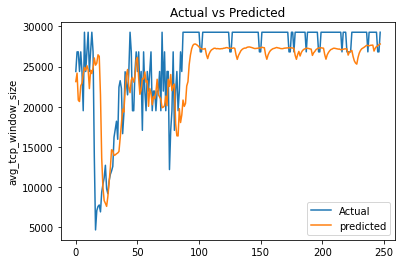

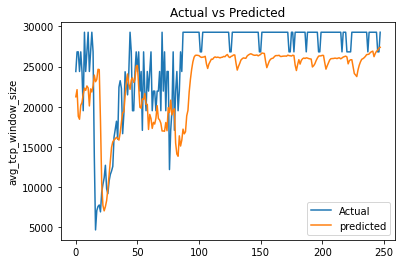



std_dev_tcp_window_size

Day  1 :
MAE-E1D1 :  6.0819426,     MAE-E2D2 :  6.212282
MSE-E1D1 :  100.1793, MSE-E2D2 :  98.183075
RMSE-E1D1 :  10.008961,     NRMSE-E1D1 :  -1.7545522,     RMSE-E2D2 :  9.908737
MAPE-E1D1 :  inf,     MAPE-E1D1 :  inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


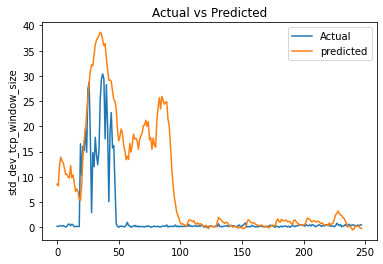

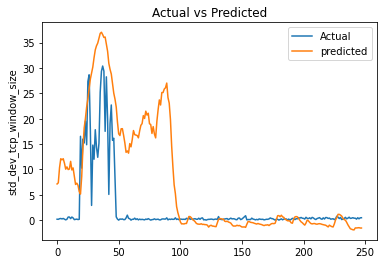


Day  2 :
MAE-E1D1 :  5.5247893,     MAE-E2D2 :  6.27357
MSE-E1D1 :  76.955536, MSE-E2D2 :  93.32815
RMSE-E1D1 :  8.77243,     NRMSE-E1D1 :  -25.574888,     RMSE-E2D2 :  9.660649
MAPE-E1D1 :  inf,     MAPE-E1D1 :  inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


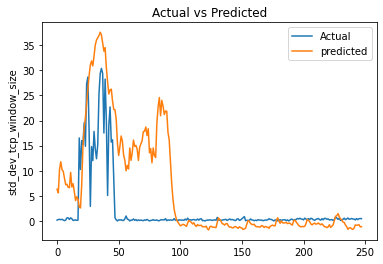

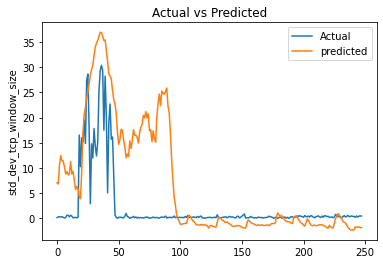


Day  3 :
MAE-E1D1 :  5.4993806,     MAE-E2D2 :  6.244119
MSE-E1D1 :  70.17121, MSE-E2D2 :  93.273346
RMSE-E1D1 :  8.376826,     NRMSE-E1D1 :  11.54657,     RMSE-E2D2 :  9.657813
MAPE-E1D1 :  inf,     MAPE-E1D1 :  inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


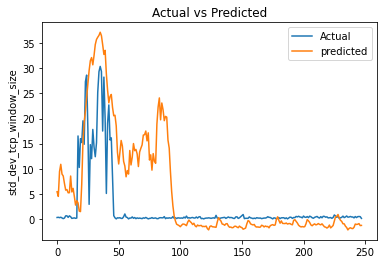

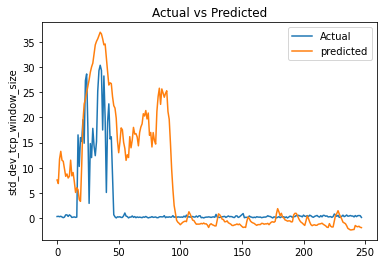


Day  4 :
MAE-E1D1 :  5.4346066,     MAE-E2D2 :  6.1551623
MSE-E1D1 :  69.76222, MSE-E2D2 :  95.945
RMSE-E1D1 :  8.352378,     NRMSE-E1D1 :  0.9095452,     RMSE-E2D2 :  9.795152
MAPE-E1D1 :  inf,     MAPE-E1D1 :  inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


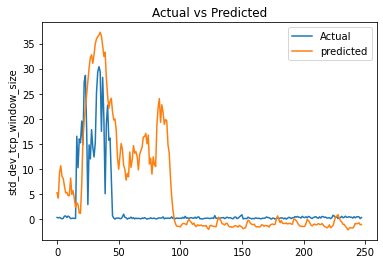

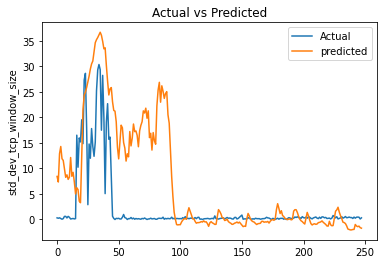


Day  5 :
MAE-E1D1 :  5.4175396,     MAE-E2D2 :  6.281976
MSE-E1D1 :  72.18663, MSE-E2D2 :  100.852066
RMSE-E1D1 :  8.496271,     NRMSE-E1D1 :  11.003553,     RMSE-E2D2 :  10.042513
MAPE-E1D1 :  inf,     MAPE-E1D1 :  inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


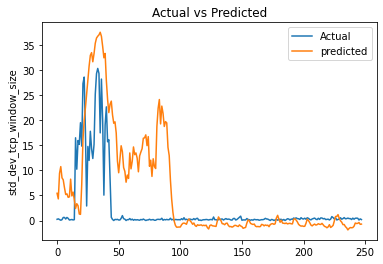

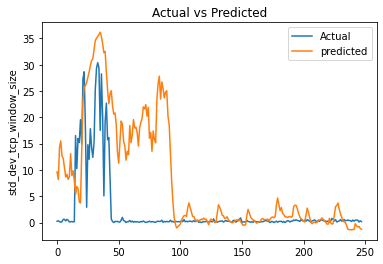



min_data_bytes

Day  1 :
MAE-E1D1 :  72.34486,     MAE-E2D2 :  76.00053
MSE-E1D1 :  8956.162, MSE-E2D2 :  10321.474
RMSE-E1D1 :  94.637,     NRMSE-E1D1 :  0.11819781,     RMSE-E2D2 :  101.59465
MAPE-E1D1 :  9.157667309045792,     MAPE-E1D1 :  9.847305715084076


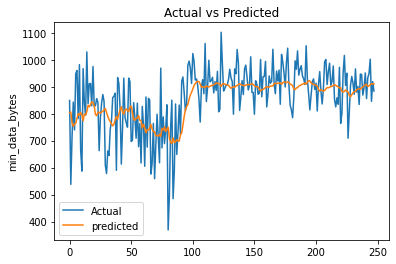

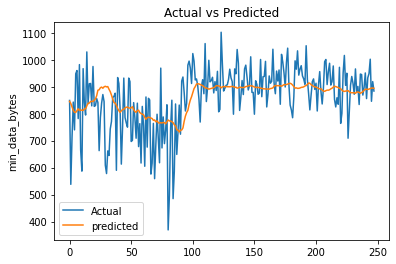


Day  2 :
MAE-E1D1 :  73.252686,     MAE-E2D2 :  75.820145
MSE-E1D1 :  9314.505, MSE-E2D2 :  10242.492
RMSE-E1D1 :  96.51168,     NRMSE-E1D1 :  0.11753974,     RMSE-E2D2 :  101.2052
MAPE-E1D1 :  9.30788442492485,     MAPE-E1D1 :  9.837047010660172


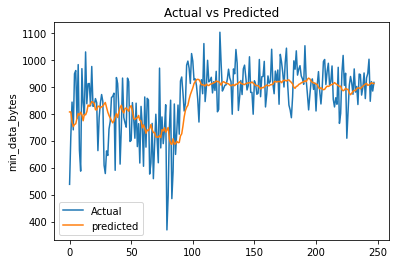

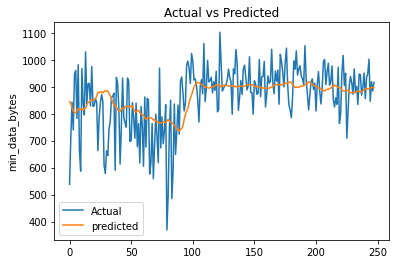


Day  3 :
MAE-E1D1 :  72.64777,     MAE-E2D2 :  74.56407
MSE-E1D1 :  9176.648, MSE-E2D2 :  9803.153
RMSE-E1D1 :  95.79482,     NRMSE-E1D1 :  0.115014695,     RMSE-E2D2 :  99.01087
MAPE-E1D1 :  9.168512374162674,     MAPE-E1D1 :  9.589236974716187


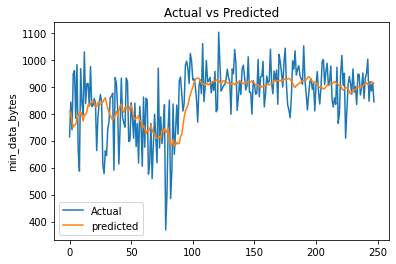

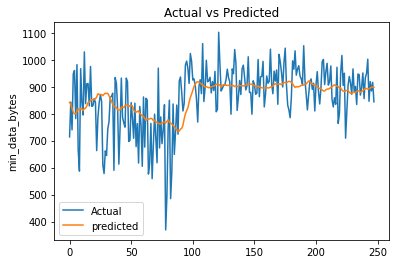


Day  4 :
MAE-E1D1 :  74.42161,     MAE-E2D2 :  74.953064
MSE-E1D1 :  9717.974, MSE-E2D2 :  9887.843
RMSE-E1D1 :  98.57978,     NRMSE-E1D1 :  0.11575857,     RMSE-E2D2 :  99.43763
MAPE-E1D1 :  9.390179812908173,     MAPE-E1D1 :  9.598220139741898


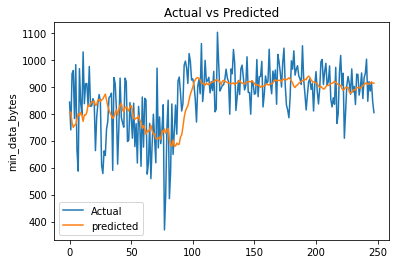

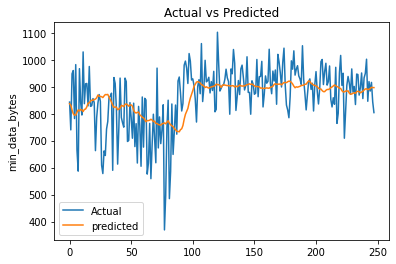


Day  5 :
MAE-E1D1 :  76.21429,     MAE-E2D2 :  76.19577
MSE-E1D1 :  10071.261, MSE-E2D2 :  10097.838
RMSE-E1D1 :  100.355675,     NRMSE-E1D1 :  0.1174205,     RMSE-E2D2 :  100.488
MAPE-E1D1 :  9.616272151470184,     MAPE-E1D1 :  9.706857055425644


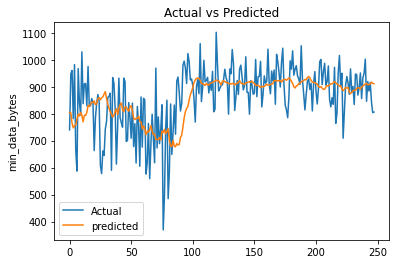

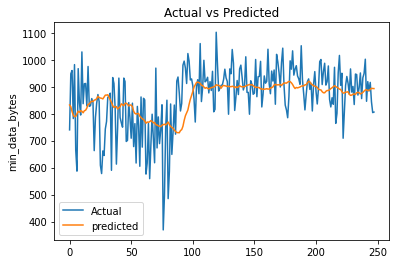



max_data_bytes

Day  1 :
MAE-E1D1 :  8697.067,     MAE-E2D2 :  8138.756
MSE-E1D1 :  158973220.0, MSE-E2D2 :  145604500.0
RMSE-E1D1 :  12608.458,     NRMSE-E1D1 :  0.118737936,     RMSE-E2D2 :  12066.669
MAPE-E1D1 :  10.926948487758636,     MAPE-E1D1 :  10.281533747911453


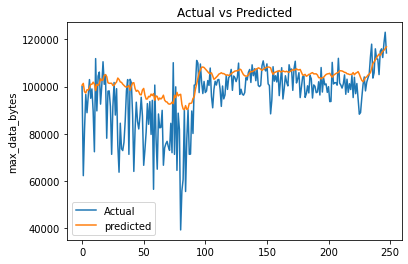

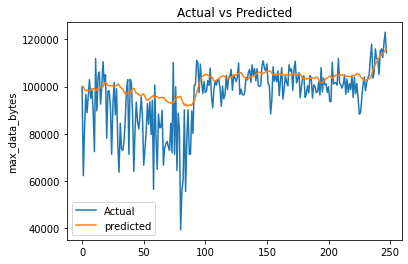


Day  2 :
MAE-E1D1 :  8277.947,     MAE-E2D2 :  8204.059
MSE-E1D1 :  155214180.0, MSE-E2D2 :  151104590.0
RMSE-E1D1 :  12458.498,     NRMSE-E1D1 :  0.1210379,     RMSE-E2D2 :  12292.461
MAPE-E1D1 :  10.504510253667831,     MAPE-E1D1 :  10.397892445325851


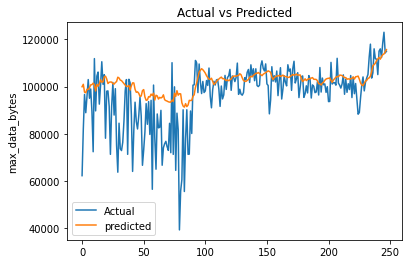

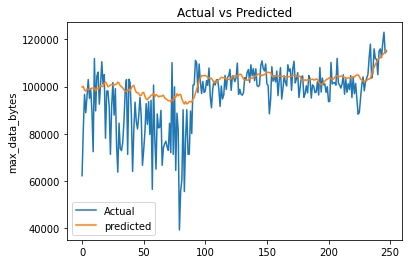


Day  3 :
MAE-E1D1 :  8182.6562,     MAE-E2D2 :  8239.7
MSE-E1D1 :  150807870.0, MSE-E2D2 :  152354430.0
RMSE-E1D1 :  12280.386,     NRMSE-E1D1 :  0.12146042,     RMSE-E2D2 :  12343.193
MAPE-E1D1 :  10.308335721492767,     MAPE-E1D1 :  10.394638031721115


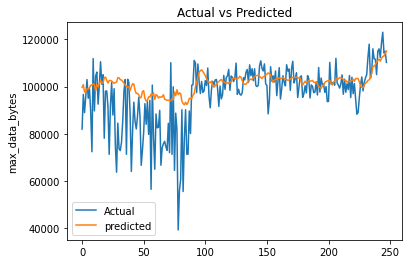

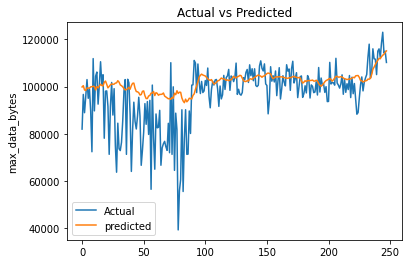


Day  4 :
MAE-E1D1 :  8228.561,     MAE-E2D2 :  8395.735
MSE-E1D1 :  151128110.0, MSE-E2D2 :  158451500.0
RMSE-E1D1 :  12293.417,     NRMSE-E1D1 :  0.123568565,     RMSE-E2D2 :  12587.752
MAPE-E1D1 :  10.337479412555695,     MAPE-E1D1 :  10.593283921480179


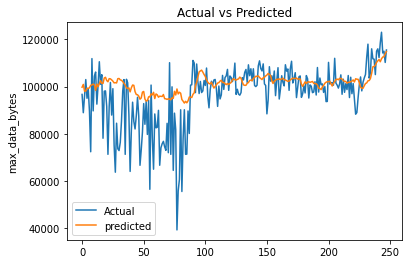

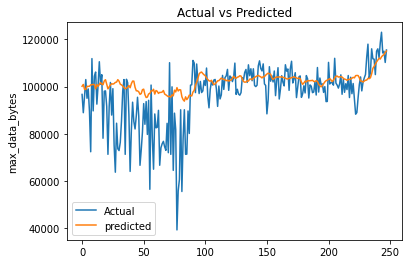


Day  5 :
MAE-E1D1 :  8317.216,     MAE-E2D2 :  8671.282
MSE-E1D1 :  154288130.0, MSE-E2D2 :  168905840.0
RMSE-E1D1 :  12421.277,     NRMSE-E1D1 :  0.12709309,     RMSE-E2D2 :  12996.378
MAPE-E1D1 :  10.415203869342804,     MAPE-E1D1 :  10.920576006174088


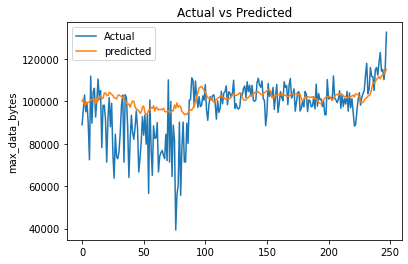

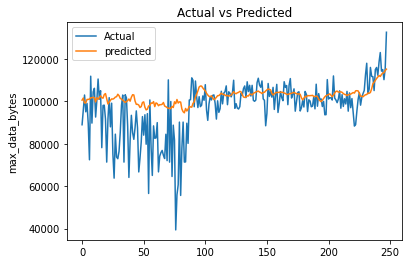



avg_databytes

Day  1 :
MAE-E1D1 :  1290.6343,     MAE-E2D2 :  1481.8491
MSE-E1D1 :  3849981.8, MSE-E2D2 :  4262903.0
RMSE-E1D1 :  1962.1371,     NRMSE-E1D1 :  0.095400006,     RMSE-E2D2 :  2064.68
MAPE-E1D1 :  6.775838881731033,     MAPE-E1D1 :  7.421794533729553


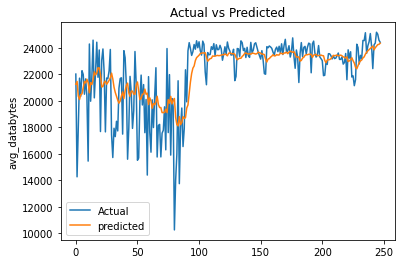

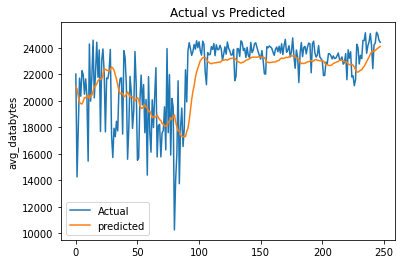


Day  2 :
MAE-E1D1 :  1371.526,     MAE-E2D2 :  1422.5378
MSE-E1D1 :  4157140.8, MSE-E2D2 :  4292615.5
RMSE-E1D1 :  2038.9067,     NRMSE-E1D1 :  0.09472535,     RMSE-E2D2 :  2071.8628
MAPE-E1D1 :  7.155962288379669,     MAPE-E1D1 :  7.241190969944


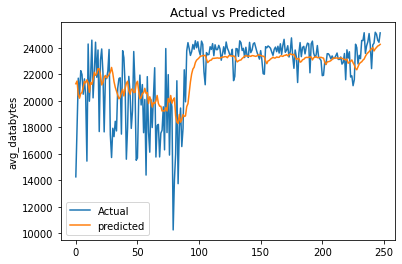

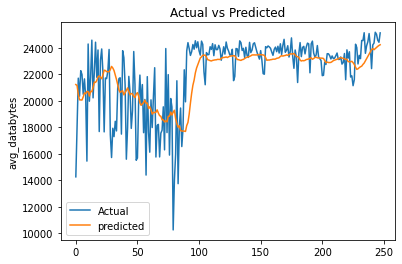


Day  3 :
MAE-E1D1 :  1402.6489,     MAE-E2D2 :  1410.6577
MSE-E1D1 :  4143587.0, MSE-E2D2 :  4185920.5
RMSE-E1D1 :  2035.5803,     NRMSE-E1D1 :  0.093119375,     RMSE-E2D2 :  2045.9523
MAPE-E1D1 :  7.233396917581558,     MAPE-E1D1 :  7.156988978385925


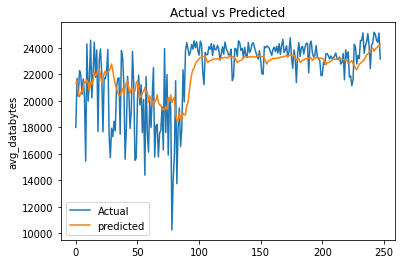

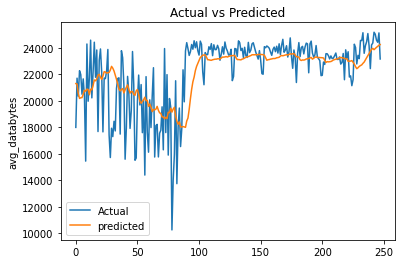


Day  4 :
MAE-E1D1 :  1435.4957,     MAE-E2D2 :  1438.0883
MSE-E1D1 :  4312494.0, MSE-E2D2 :  4300062.5
RMSE-E1D1 :  2076.6545,     NRMSE-E1D1 :  0.09427221,     RMSE-E2D2 :  2073.6592
MAPE-E1D1 :  7.3693737387657166,     MAPE-E1D1 :  7.282818853855133


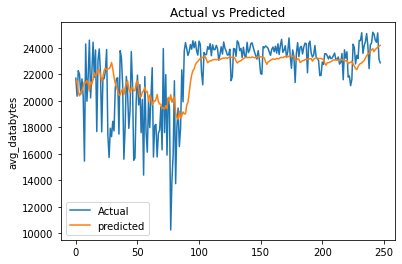

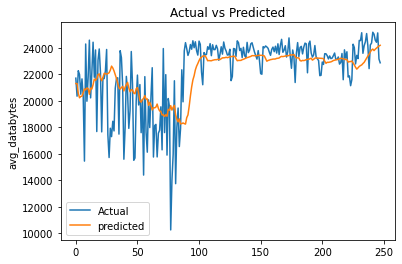


Day  5 :
MAE-E1D1 :  1477.8175,     MAE-E2D2 :  1495.7362
MSE-E1D1 :  4530090.0, MSE-E2D2 :  4509169.0
RMSE-E1D1 :  2128.401,     NRMSE-E1D1 :  0.09661052,     RMSE-E2D2 :  2123.4805
MAPE-E1D1 :  7.5705163180828094,     MAPE-E1D1 :  7.548884302377701


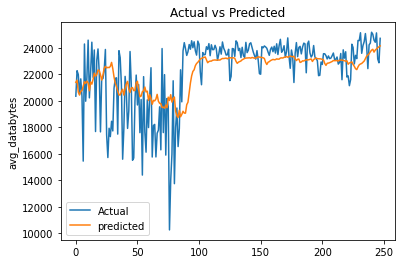

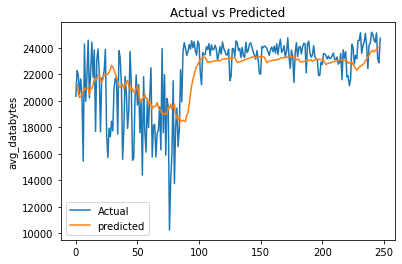



std_dev_databytes

Day  1 :
MAE-E1D1 :  1264.274,     MAE-E2D2 :  1270.1008
MSE-E1D1 :  3977599.0, MSE-E2D2 :  3964424.8
RMSE-E1D1 :  1994.3918,     NRMSE-E1D1 :  0.09464035,     RMSE-E2D2 :  1991.0863
MAPE-E1D1 :  7.230112701654434,     MAPE-E1D1 :  7.224459201097488


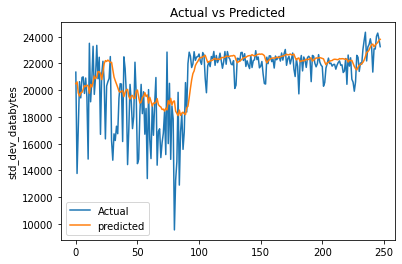

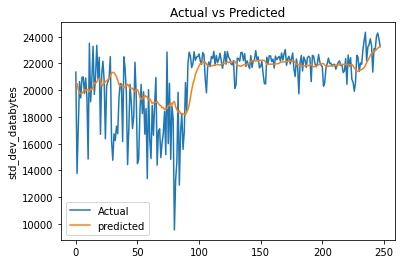


Day  2 :
MAE-E1D1 :  1263.3398,     MAE-E2D2 :  1284.2688
MSE-E1D1 :  4129027.2, MSE-E2D2 :  4203361.0
RMSE-E1D1 :  2032.0009,     NRMSE-E1D1 :  0.09676311,     RMSE-E2D2 :  2050.21
MAPE-E1D1 :  7.259288430213928,     MAPE-E1D1 :  7.3647648096084595


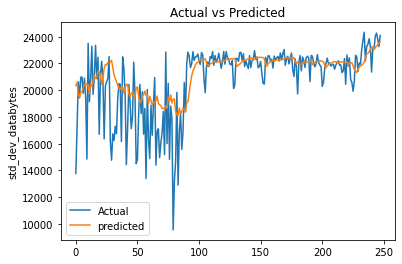

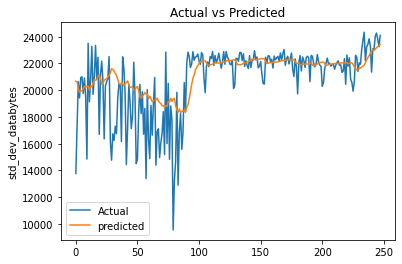


Day  3 :
MAE-E1D1 :  1274.2589,     MAE-E2D2 :  1295.4874
MSE-E1D1 :  4135210.0, MSE-E2D2 :  4200360.5
RMSE-E1D1 :  2033.5216,     NRMSE-E1D1 :  0.096475765,     RMSE-E2D2 :  2049.478
MAPE-E1D1 :  7.280892878770828,     MAPE-E1D1 :  7.385487109422684


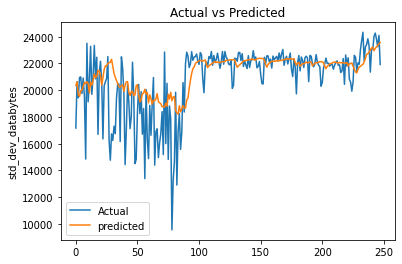

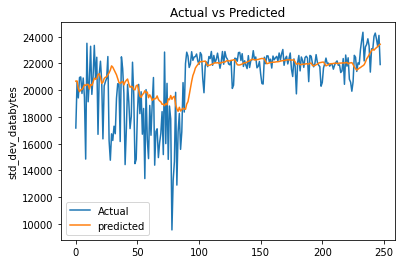


Day  4 :
MAE-E1D1 :  1303.5823,     MAE-E2D2 :  1326.5648
MSE-E1D1 :  4284697.0, MSE-E2D2 :  4323211.5
RMSE-E1D1 :  2069.951,     NRMSE-E1D1 :  0.09786437,     RMSE-E2D2 :  2079.2334
MAPE-E1D1 :  7.436651736497879,     MAPE-E1D1 :  7.534053176641464


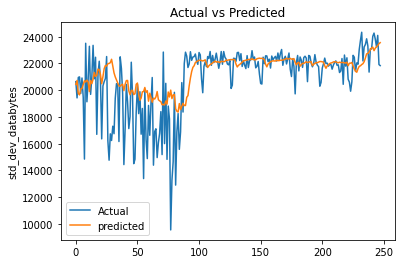

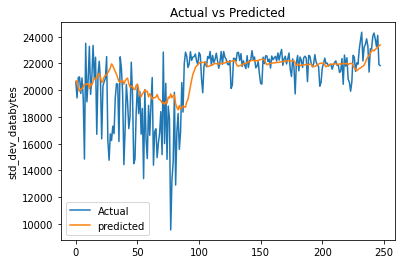


Day  5 :
MAE-E1D1 :  1319.339,     MAE-E2D2 :  1375.2316
MSE-E1D1 :  4495573.0, MSE-E2D2 :  4505689.0
RMSE-E1D1 :  2120.2766,     NRMSE-E1D1 :  0.10003064,     RMSE-E2D2 :  2122.661
MAPE-E1D1 :  7.5547561049461365,     MAPE-E1D1 :  7.778233289718628


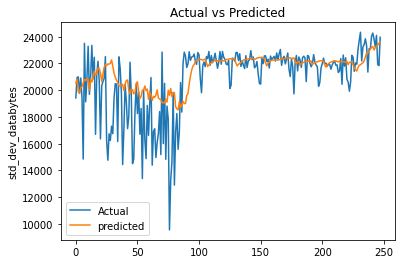

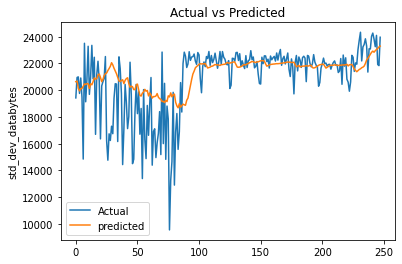



total_data_bytes

Day  1 :
MAE-E1D1 :  436887.1,     MAE-E2D2 :  488100.47
MSE-E1D1 :  488610170000.0, MSE-E2D2 :  492332900000.0
RMSE-E1D1 :  699006.56,     NRMSE-E1D1 :  0.093341395,     RMSE-E2D2 :  701664.4
MAPE-E1D1 :  7.016614079475403,     MAPE-E1D1 :  7.633820176124573


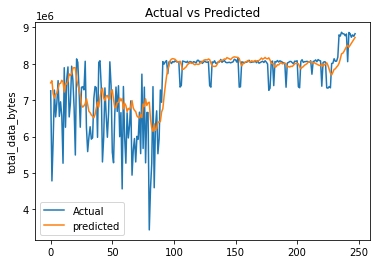

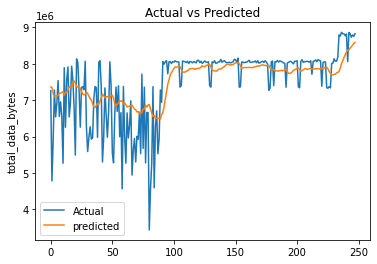


Day  2 :
MAE-E1D1 :  489145.28,     MAE-E2D2 :  541228.5
MSE-E1D1 :  495367850000.0, MSE-E2D2 :  536818000000.0
RMSE-E1D1 :  703823.75,     NRMSE-E1D1 :  0.0979091,     RMSE-E2D2 :  732678.6
MAPE-E1D1 :  7.609320431947708,     MAPE-E1D1 :  8.315524458885193


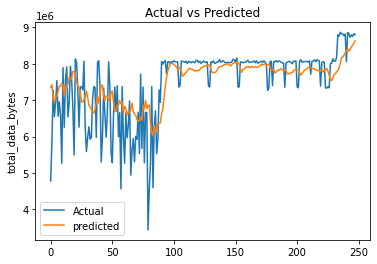

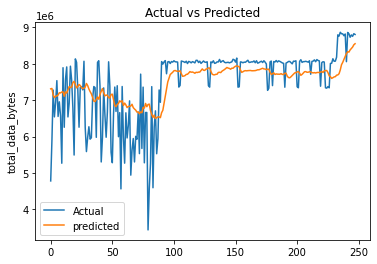


Day  3 :
MAE-E1D1 :  537846.56,     MAE-E2D2 :  565384.56
MSE-E1D1 :  501040050000.0, MSE-E2D2 :  548192750000.0
RMSE-E1D1 :  707841.8,     NRMSE-E1D1 :  0.09915993,     RMSE-E2D2 :  740400.4
MAPE-E1D1 :  8.090866357088089,     MAPE-E1D1 :  8.548996597528458


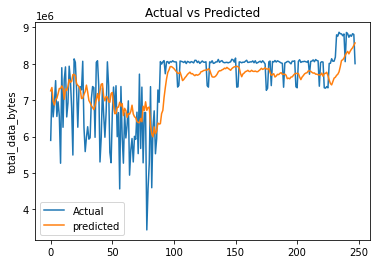

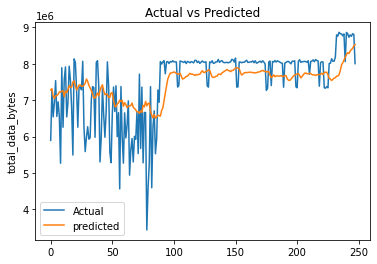


Day  4 :
MAE-E1D1 :  570493.25,     MAE-E2D2 :  578319.25
MSE-E1D1 :  531412500000.0, MSE-E2D2 :  567038640000.0
RMSE-E1D1 :  728980.44,     NRMSE-E1D1 :  0.100884855,     RMSE-E2D2 :  753019.7
MAPE-E1D1 :  8.447633683681488,     MAPE-E1D1 :  8.703108876943588


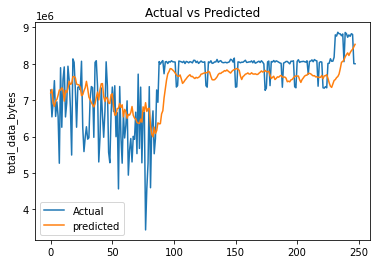

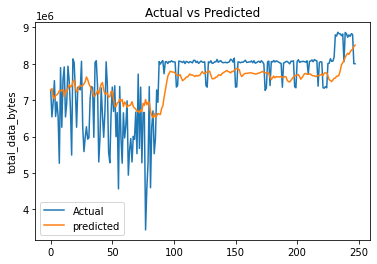


Day  5 :
MAE-E1D1 :  603763.1,     MAE-E2D2 :  594000.4
MSE-E1D1 :  571345500000.0, MSE-E2D2 :  592522700000.0
RMSE-E1D1 :  755874.0,     NRMSE-E1D1 :  0.103035174,     RMSE-E2D2 :  769754.94
MAPE-E1D1 :  8.863654732704163,     MAPE-E1D1 :  8.925672620534897


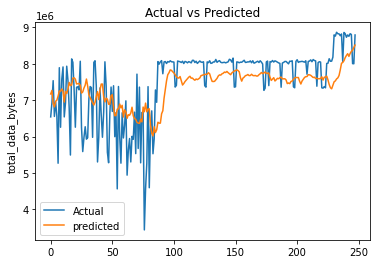

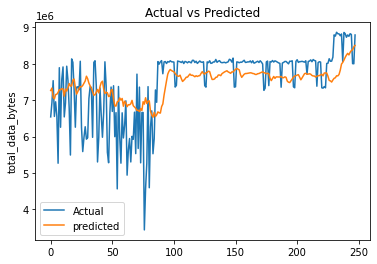

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from plotnine import ggplot, aes, geom_line
import matplotlib.pyplot as plt



def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
for index,i in enumerate(train_df.columns):
  print(i)
  
  for j in range(1,6):
  
   
    print()
    print("Day ",j,":")
   #print("Test-E1D1 : ",y_test[:,j-1,index])
    #print("Pred-E1D1 : ",pred1_e1d1[:,j-1,index])
    print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]),end=",     ")
    print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
    RMSE=np.sqrt(mean_squared_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))

     
    
    print("MSE-E1D1 : ",mean_squared_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]),end=", ")
    print("MSE-E2D2 : ",mean_squared_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
    print("RMSE-E1D1 : ",np.sqrt(mean_squared_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index])),end=",     ")
    print("NRMSE-E1D1 : ", np.mean(np.sqrt(mean_squared_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))/pred1_e2d2[:,j-1,index]),end=",     ")
    #(np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))) * 10
    #(np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))) * 100 
    print("RMSE-E2D2 : ",np.sqrt(mean_squared_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index])))
    #print("RMSPE-E1D1 : ",(np.sqrt(np.mean(mean_squared_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]))/y_test[:,j-1,index]))*100,end=",     ")
    #print("RMSPE-E2D2 : ",(np.sqrt(np.mean(mean_squared_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))/y_test[:,j-1,index]))*100)
    
    print("MAPE-E1D1 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]),end=",     ")
    print("MAPE-E1D1 : ",mean_absolute_percentage_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))

   
   
                   

   
    
    plt.plot( list(y_test[:,j-1,index]),)
    plt.plot( list(pred1_e1d1[:,j-1,index]))
    
    
    #plt.plot( list(pred1_e1d1[:,j-1,index]),kind='line', marker='d')
    
    #plt.bar(list(y_test[:,j-1,index] - list(pred1_e1d1[:,j-1,index])),10,2.5)
    #ax = plt.gca()
    #plt.xlim([y_test[:,j-1,index], list(pred1_e1d1[:,j-1,index]))
    
    #df = pd.DataFrame({'a': [100, 200, 150, 175],
    #               'b': [430, 30, 20, 10]})
    
    #df['b'].plot(kind='bar', color='y')
    #df['a'].plot(kind='line', marker='d')

    plt.title("Actual vs Predicted")
    plt.ylabel(i)
    plt.legend(('Actual','predicted'))
    
    
    plt.show()

    

    plt.plot( list(y_test[:,j-1,index]))
    plt.plot( list(pred1_e2d2[:,j-1,index]))
    
    plt.title("Actual vs Predicted")
    plt.ylabel(i)
    plt.legend(('Actual','predicted'))
    plt.show()
  print()
  print()
  

From the above output we can observe that in some cases E2D2 model has 
performed better than E1D1 model with less error. Training different models with different number of stacked layers and creating an ensemble model also performs well. 

Note: The results vary with respect to the dataset. If we stack more layers it may also lead to overfitting. So the no of layers to be stackes acts as a hyper parameter. 